# Data Mining (CpSc 8650) Course Project  Quality Evaluation of Skull Stripped Brain MRI Images

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
# import nibabel as nib
import random
import csv
from scipy import ndimage
import pandas as pd
from tensorflow import keras
import tensorflow.keras.optimizers as optimizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
# load and return data 
def load_data(csv_file_path, test_size = 0.3, x_names = [], y_names = []):

    
    """
    Load training data and split it into training and validation set
    """
    print ("Loading data from: ",csv_file_path)
    #reads CSV file into a single dataframe variable
    data_df = pd.read_csv(csv_file_path, names=x_names+y_names, skiprows=1)

    #yay dataframes, we can select rows and columns by their names
    X = data_df[x_names].values
    #and our steering commands as our output data
    y = data_df[y_names ].values

    return X, y

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    #Resize width, height and depth
    volume = resize_volume(volume)
    
    return volume

In [9]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [0,-5,5,-10,10,15,-15]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, labels):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, labels


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



In [10]:
label_file_path = os.path.join(os.path.abspath(os.pardir), "dataset", "Label_file.csv")
X, y = load_data(label_file_path, x_names = ["Filename"], y_names = ["Recognizable-Facial-Feature","Brain-Feature-Loss"])

Loading data from:  /home/rkaranj/Data Mining/New/dataset/Label_file.csv


In [11]:
y[y=='Yes'] = 1
y[y=='No'] = 0

In [14]:
def get_model(width=128, height=128, depth=64):
        """Build a 3D convolutional neural network model."""

        inputs = keras.Input((width, height, depth, 1))

        x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
        x = layers.MaxPool3D(pool_size=2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
        x = layers.MaxPool3D(pool_size=2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
        x = layers.MaxPool3D(pool_size=2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.GlobalAveragePooling3D()(x)
        x = layers.Dense(units=256, activation="relu")(x)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Dense(units=2, activation="sigmoid")(x)

        # Define the model.
        model = keras.Model(inputs, outputs, name="3dcnn")
        return model

Fold:1
Data Loaded
Epoch 1/100
44/44 [==============================] - 128s 3s/step - loss: 0.6602 - acc: 0.6441 - val_loss: 0.6858 - val_acc: 0.5779
Epoch 2/100
44/44 [==============================] - 127s 3s/step - loss: 0.5291 - acc: 0.9532 - val_loss: 0.6818 - val_acc: 0.5779
Epoch 3/100
44/44 [==============================] - 127s 3s/step - loss: 0.4379 - acc: 0.9790 - val_loss: 0.6746 - val_acc: 0.5779
Epoch 4/100
44/44 [==============================] - 127s 3s/step - loss: 0.3687 - acc: 0.9809 - val_loss: 0.6653 - val_acc: 0.9087
Epoch 5/100
44/44 [==============================] - 127s 3s/step - loss: 0.3195 - acc: 0.9828 - val_loss: 0.6655 - val_acc: 0.4221
Epoch 6/100
44/44 [==============================] - 126s 3s/step - loss: 0.2905 - acc: 0.9809 - val_loss: 0.6715 - val_acc: 0.4221
Epoch 7/100
44/44 [==============================] - 127s 3s/step - loss: 0.2622 - acc: 0.9790 - val_loss: 0.6678 - val_acc: 0.4221
Epoch 8/100
44/44 [==============================] - 127s

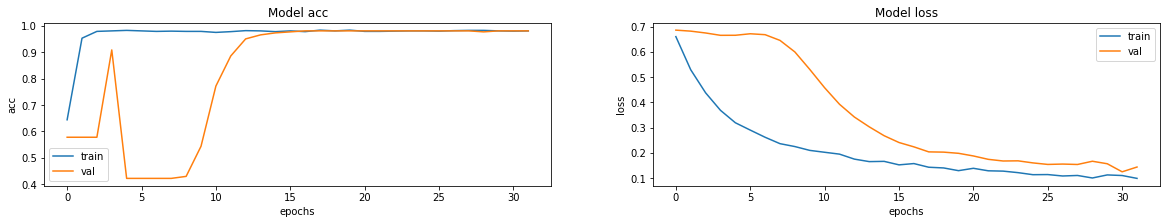

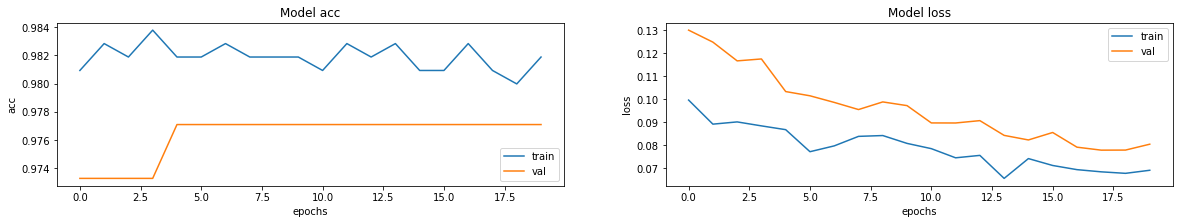

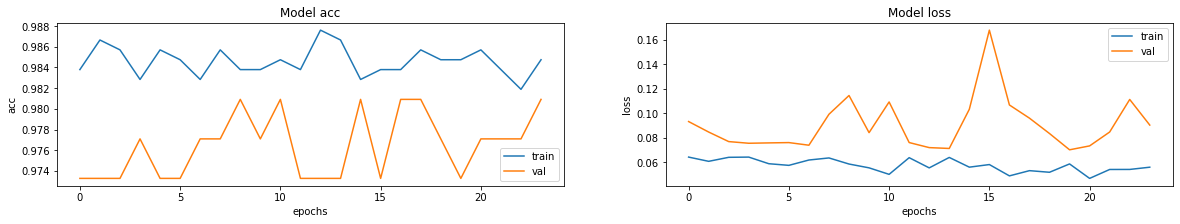

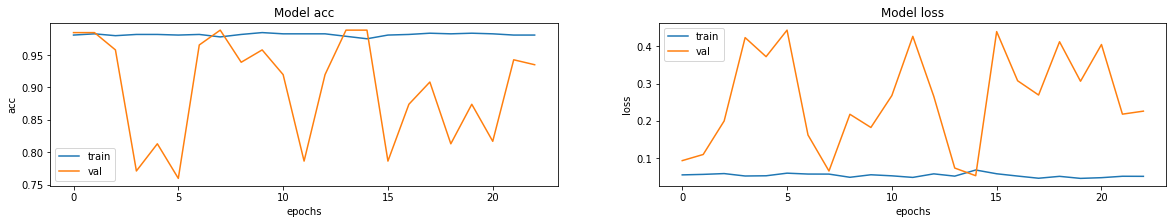

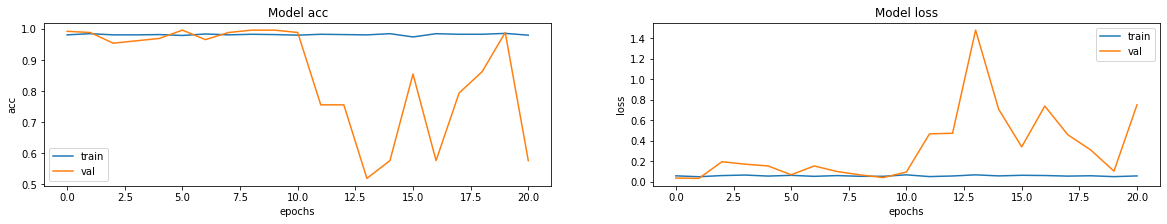

In [15]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5,shuffle=True,random_state=1)
skf.get_n_splits(X, y)
fold = 0

model = get_model(width=128, height=128, depth=64)
for train_index, test_index in skf.split(X):
    fold+=1
    print("Fold:"+str(fold))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    iteration=0
    #print(len(y_train), len(y_test))
    # X_train_data = np.array([process_scan(os.path.join(os.path.abspath(os.pardir), "dataset", "files", path[0]+".gz")) for path in X_train])
    # X_valid_data = np.array([process_scan(os.path.join(os.path.abspath(os.pardir), "dataset", "files", path[0]+".gz")) for path in X_test])
    
    outfileTrain = "Fold " + str(fold) + " Checkpoints.pkl"
    outfileTest = "Fold " + str(fold) + " Checkpoints test set.pkl"
    #X_train_valid = [X_valid_data]
#     with open(outfile, "wb") as f:
#         pickle.dump(X_train_valid, f)
    #print(len(X_valid_data), len(y_test))
    # Load the objects back
    with open(outfileTrain, "rb") as f:
        [X_train_data, abc] = pickle.load(f)
        
    with open(outfileTest, "rb") as f:
        [X_valid_data] = pickle.load(f)
    print("Data Loaded")
    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_data,y_train.astype("float32")))
    validation_loader = tf.data.Dataset.from_tensor_slices((X_valid_data, y_test.astype("float32")))
    
    batch_size = 24
    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(X_train_data))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(X_valid_data))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    # Build model.
    
    # Compile model.
    initial_learning_rate = 0.00001
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"],
    )

    
    # Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        "3d_image_classification_relu.h5", save_best_only=True
    )

    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

    # Train the model, doing validation at the end of each epoch
    epochs = 100
    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[checkpoint_cb, early_stopping_cb],
    )
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "loss"]):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

In [16]:
model.save("Final Model.h5")

## Displaying Image

In [7]:
from matplotlib import pyplot
model = keras.models.load_model('Final Model.h5')
pyplot.plot(model.history['val_acc'])
pyplot.show()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_6 (Conv3D)           (None, 126, 126, 62, 16)  448       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 63, 63, 31, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 63, 63, 31, 16)   64        
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 31, 16)    0         
                                                             

In [ ]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5,shuffle=True,random_state=1)
skf.get_n_splits(X, y)
fold = 0

for train_index, test_index in skf.split(X):
    fold+=1
    print("Fold:"+str(fold))
#     X_train, X_test = X[train_index], X[test_index]
    y_test = y[test_index]
    iteration=0

    outfileTrain = "Fold " + str(fold) + " Checkpoints.pkl"
    outfileTest = "Fold " + str(fold) + " Checkpoints test set.pkl"
    
    with open(outfileTrain, "rb") as f:
        [X_train_data, abc] = pickle.load(f)
        
    with open(outfileTest, "rb") as f:
        [X_valid_data] = pickle.load(f)
        
    result = model.evaluate(X_valid_data, y_test)
    
    

In [1]:

image = X_train_data
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 70]), cmap="gray")
plt.show()

NameError: name 'X_train_data' is not defined

### Predict with a image

In [ ]:
from tensorflow import keras
model = keras.models.load_model("3d_image_classification_relu.h5")

In [ ]:
file = process_scan('../dataset/files/IXI002-Guys-0828-T1_bse_less_s5_r1.nii.gz')
file = tf.expand_dims(file, axis=0)

prediction = model.predict(file)


# yes,no = prediction[0] * 100, (1-prediction[0]) *100

# print("Yes=",yes[0],"No=",no[0])
# if(yes[0]>50):
#     print("Facial Feature Recognizable")
# else:
#     print("Facial Feature not recognizable")

In [ ]:
print("Face Recognizable:",prediction[0][0]>0.5)
print("Brain Feature loss:",prediction[0][1]>0.5)

In [ ]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5,shuffle=True,random_state=1)
skf.get_n_splits(X, y)
fold = 0
for train_index, test_index in skf.split(X):
    fold +=1  
    print("fold",fold)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    outfileTrain = "Fold " + str(fold) + " Checkpoints.pkl"
    outfileTest = "Fold " + str(fold) + " Checkpoints test set.pkl"
    with open(outfileTrain, "rb") as f:
        [X_train_data, abc] = pickle.load(f)
        
    with open(outfileTest, "rb") as f:
        [X_valid_data] = pickle.load(f)
    print("data loaded")
    
    model.evaluate(X_train_data,y_train)

In [ ]:
model.summary()